In [1]:
import scipy as sp
import numpy as np_
import random

import pennylane as qml
from pennylane import numpy as np

from IPython.display import display, Latex
import matplotlib.pyplot as plt

# qnode device
dev = qml.device("default.mixed", wires = 1)

# == Hamiltonain setup == 
Coeff_ham = [1]
Obs = [qml.PauliZ(0)]
Hamiltonian = qml.Hamiltonian(Coeff_ham, Obs)

In [2]:
# == Define global variables ==
Gamma_ps = 0
Tau_global = 5e-2

def Dephase_factor(tau):
    """ Take tau and return gamma based on the following relation."""

    Calculate_Gamma = 1 - np.exp(-2 * tau)
    
    return Calculate_Gamma    # Return gamma

In [3]:
#  == Generate circuit ==
# Stage_1: Generate dephase
@qml.qnode(dev)
def Dephase_circuit(phi):
    
    global Tau_global 
    
    # Calculate dephase factor with fixed tau
    gamma_dephase_in = Dephase_factor(Tau_global)
    
    qml.Hadamard(wires=0)
    
    # Time_evo t fixed as -phi/2
    qml.ApproxTimeEvolution(Hamiltonian, -phi/2, 1)
    
    qml.PhaseDamping(gamma_dephase_in, wires = 0)
    
    qml.Hadamard(wires=0)
    
    return qml.density_matrix(wires=0)


# Stage_2: Post-selection
@qml.qnode(dev)
def Post_selection(phi):
    global Gamma_ps
    gamma_ps = Gamma_ps
    
    rho_dephase = Dephase_circuit(phi)
    Kraus_oper = np.array([ [np.sqrt(1-gamma_ps), 0], [0, 1] ])
    
    Num = Kraus_oper @ rho_dephase @ Kraus_oper.conj().T
    Den = np.trace(Kraus_oper @ rho_dephase @ Kraus_oper.conj().T)
    rho_ps = Num / (Den)
    qml.QubitDensityMatrix(rho_ps, wires=0)
    
    return qml.density_matrix(wires=0)

In [4]:
# == CFI; cost function to maximize ==
def Cost_function(phi):
    # Type casting for phi
    para = np.array([phi], requires_grad = 'True')

    Cost_function = qml.qinfo.classical_fisher(Post_selection)(para[0])
    # Cost_function = round( np.array(Temp, requires_grad = False).numpy(),10)
    
    # Value-bound: 0 ~ 1
    # if, 1 - cf = min -> then, cf = max
    return -Cost_function

In [6]:
def BFGS(Sweep_Data, paras, gamma_ps_select):
    # Create Data array
    PHI = np_.arange(Sweep_Data[0], Sweep_Data[1], Sweep_Data[2]).reshape(-1, 1)
    Data = np_.zeros((len(PHI), 3))
    
    Data[:, 0] = PHI.squeeze()
    
    #INDEX CONSTANT
    CFI_INDEX, PHI_INDEX, BEFORE_OPT_INDEX = 1, 0, 2
    
    # Set global variables 
    global Gamma_ps
    Gamma_ps = gamma_ps_select
    
    # Before optimization; CFI DATA
    for Phi_index in range(len(PHI)):
        Data[Phi_index][BEFORE_OPT_INDEX] = -Cost_function(paras)
        
    # Set constraints for L-BFGS-B
    Seacrh_bound = np.array([0, np.pi * 4]).numpy()
    
    # Optimize begin 
    for Phi_index in range(len(PHI)):
        Constraints = sp.optimize.Bounds([Seacrh_bound[0]], [Seacrh_bound[1]])
        
        Result_BFGS = sp.optimize.minimize(Cost_function, paras, method = 'L-BFGS-B', bounds = Constraints)
        Data[Phi_index][CFI_INDEX] = -Result_BFGS.fun
        
        
    return Data

In [7]:
# == Sweep for 0 ~ pi*3 == 
Step = np.pi / 25     #1e-1
Sweep_data = np_.array([1e-4, np.pi * 3 + 1e-4, Step])

Para_init = random.uniform(0, np.pi)

Gamma_ps_preset = 0.8
Optimized_Result = BFGS(Sweep_data, Para_init, Gamma_ps_preset)

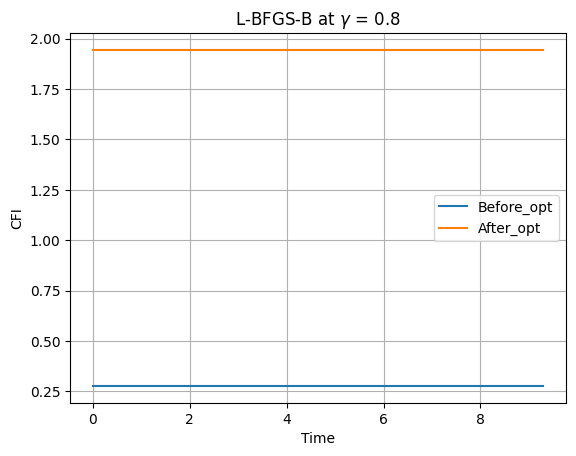

In [9]:
plt.plot(Optimized_Result[:, 0], Optimized_Result[:, 2], label = 'Before_opt')
plt.plot(Optimized_Result[:, 0], Optimized_Result[:, 1], label = 'After_opt')

plt.title(f'L-BFGS-B at $\gamma$ = {Gamma_ps}')
plt.xlabel('Time')
plt.ylabel('CFI')
plt.legend()
plt.grid() 